## Welcome to Week 4, Day 2 - introducing LangGraph!

In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
import random

In [2]:
# Some useful constants

nouns = ["Cabbages", "Unicorns", "Toasters", "Penguins", "Bananas", "Zombies", "Rainbows", "Eels", "Pickles", "Muffins"]
adjectives = ["outrageous", "smelly", "pedantic", "existential", "moody", "sparkly", "untrustworthy", "sarcastic", "squishy", "haunted"]

In [2]:
# Our favorite first step! Crew was doing this for us, by the way.
load_dotenv(override=True)

True

In [4]:
def shout(text: Annotated[str, "something to be shouted"]) -> str:
    print(text.upper())
    return text.upper()

shout("hello")

HELLO


'HELLO'

### A word about "Annotated"

You probably know this; type hinting is a feature in Python that lets you specify the type of something:

`my_favorite_things: List`

But you may not know this:

You can also use something called "Annotated" to add extra information that somebody else might find useful:

`my_favorite_things: Annotated[List, "these are a few of mine"]`

LangGraph needs us to use this feature when we define our State object.

It wants us to tell it what function it should call to update the State with a new value.

This function is called a **reducer**.

LangGraph provides a default reducer called `add_messages` which takes care of the most common case.

And that hopefully explains why the State looks like this.

במקום שנכתוב בקוד ידנית איזו פונקציה היא ה־ reducer,
אנחנו פשוט נצמיד אותה לשדה בתור annotation.

### Step 1: Define the State object

You can use any python object; but it's most common to use a TypedDict or a Pydantic BaseModel.

**💡 What's happening here:**
- **messages** is a list type field (list)
- We mark it with add_messages as a **Reducer**.
- Python ignores this, but LangGraph knows how to use this information to know how to combine lists of messages from different States.

**🧩 What does "add_messages" do?**
- The add_messages is a pre-built **Reducer** that LangGraph provides.
- When there are two states, each containing a list of messages, it simply concatenates these lists.
- For example:
  ```python
  old_state.messages = ["Hi"]
  new_state.messages = ["How are you?"]
  # And after the merge we will get:
  ["Hi", "How are you?"]
  ```

In [5]:
# The State defines the data that is stored along the graph. In our case - a list of messages.
class State(BaseModel):
        
    messages: Annotated[list, add_messages]


### Step 2: Start the Graph Builder with this State class

In [6]:
# We are not passing a State object, but the class itself.
# LangGraph will create new State instances on its own at runtime. At this point we just tell it what type of state it will use.
graph_builder = StateGraph(State)

### Step 3: Create a Node

A node can be any python function.

The reducer that we set before gets automatically called to combine this response with previous responses


In [7]:
def our_first_node(old_state: State) -> State:

    reply = f"{random.choice(nouns)} are {random.choice(adjectives)}"
    messages = [{"role": "assistant", "content": reply}]

    new_state = State(messages=messages)

    return new_state

# Add node to the Graph, ("node name", the function of the node)
graph_builder.add_node("first_node", our_first_node)

### Step 4: Create Edges

In [8]:
# LangGraph comes with two useful constants:
# START – the starting point of the workflow
# END – the ending point of the workflow
# In our example: [START] → [first_node] → [END]

graph_builder.add_edge(START, "first_node")
graph_builder.add_edge("first_node", END)

### Step 5: Compile the Graph

In [9]:
graph = graph_builder.compile()

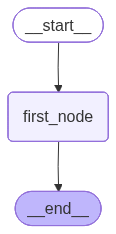

In [10]:
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! Showtime!

In [11]:
def chat(user_input: str, history):
    # Convert the user message to a standard message structure
    message = {"role": "user", "content": user_input}
    messages = [message]
    state = State(messages=messages)
    # Run the graph and return the new state
    result = graph.invoke(state)
    # Print and return the result
    print(result)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='79733b86-4df1-4df3-9ece-17b6df9732eb'), AIMessage(content='Eels are sparkly', additional_kwargs={}, response_metadata={}, id='c39633ea-3db7-4b68-9132-053e98f09c4e')]}
{'messages': [HumanMessage(content='Is that so ?', additional_kwargs={}, response_metadata={}, id='b0d24f7f-e244-4109-9075-b078595350a3'), AIMessage(content='Cabbages are sarcastic', additional_kwargs={}, response_metadata={}, id='de401b26-b644-42de-b704-61708cbf8fe7')]}


**What goes into messages?**
- HumanMessage for what the user wrote (“Hi there!”, “Is that so?” …)
- AIMessage for what the node returned (“Muffins are haunted.” …)

### But why did I show you that?

To make the point that LangGraph is all about python functions - it doesn't need to involve LLMs!!

Now we'll do the 5 steps again, but in 1 shot:

In [3]:
# Step 1: Define the State object
class State(BaseModel):
    messages: Annotated[list, add_messages]

In [4]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)

In [5]:
# Step 3: Create a Node

# We will use ChatOpenAI, which comes from LangChain, to talk to OpenAI.
llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot_node(old_state: State) -> State:
    # The function receives old_state (which contains messages - the list of messages in the conversation),
    # sends these messages to the model and receives the model's response.
    response = llm.invoke(old_state.messages)
    # Creates a new state where the messages field contains *only* this response and returns the new state.
    new_state = State(messages=[response])
    return new_state

graph_builder.add_node("chatbot", chatbot_node)

In [6]:
# Step 4: Create Edges
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [8]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
# display(Image(graph.get_graph().draw_mermaid_png()))
print(graph.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	chatbot(chatbot)
	__end__([<p>__end__</p>]):::last
	__start__ --> chatbot;
	chatbot --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



### That's it! And, let's do this:

In [16]:
def chat(user_input: str, history):
    initial_state = State(messages=[{"role": "user", "content": user_input}])
    result = graph.invoke(initial_state)
    print(result)
    return result['messages'][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Hi there !', additional_kwargs={}, response_metadata={}, id='37aee0eb-95d5-4af3-9ded-ac1f99ed5998'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 10, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CP6QFXv6KO3Fwws69h5e4Tjd5q9pz', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--e5c297e9-b212-4ad5-af6e-2e6fc0813536-0', usage_metadata={'input_tokens': 10, 'output_tokens': 9, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
{'messages': [HumanMessage(co

<u>**נשים לב כי אין כאן עדיין זיכרון**</u>
- המודל לא "זוכר" שום דבר מהעבר בגלל שכרגע בכל הרצה אנחנו 
- **מזינים רק את ההודעה האחרונה**
- לא את ההיסטוריה של השיחה כולה.
- כלומר:

ה־ State שנשלח למודל בכל פעם כולל רק את ההודעה הנוכחית.<br> 
אין שום מנגנון שמוסיף את ההודעות הקודמות לשדה messages.<br>
לכן המודל “שוכח” הכל בכל פנייה חדשה.